In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
color_mode = "rgb"
number_colour_layers = 3
image_size = (640, 640)
image_shape = image_size + (number_colour_layers,)
batch_size = 4
img_width = 640
img_height = 640
training_data_path = "Train/*"
test_data_path = "Test"
SEED = 42

In [3]:
img_folder = "GSVImages/"

imgs = tf.keras.preprocessing.image_dataset_from_directory(
    img_folder, 
    batch_size=32, 
    image_size=(640,640),
    labels = None,
)
paths = imgs.file_paths


Found 23730 files belonging to 1 classes.


Code Chuck bellow removes bad images

In [4]:
# from struct import unpack
# from tqdm import tqdm
# import os
# import os.path as osp

# marker_mapping = {
#     0xffd8: "Start of Image",
#     0xffe0: "Application Default Header",
#     0xffdb: "Quantization Table",
#     0xffc0: "Start of Frame",
#     0xffc4: "Define Huffman Table",
#     0xffda: "Start of Scan",
#     0xffd9: "End of Image"
# }


# class JPEG:
#     def __init__(self, image_file):
#         with open(image_file, 'rb') as f:
#             self.img_data = f.read()
    
#     def decode(self):
#         data = self.img_data
#         while(True):
#             marker, = unpack(">H", data[0:2])
#             # print(marker_mapping.get(marker))
#             if marker == 0xffd8:
#                 data = data[2:]
#             elif marker == 0xffd9:
#                 return
#             elif marker == 0xffda:
#                 data = data[-2:]
#             else:
#                 lenchunk, = unpack(">H", data[2:4])
#                 data = data[2+lenchunk:]            
#             if len(data)==0:
#                 break        


# bads = []
# root_img = "C:\ML"
# for i in tqdm(paths):
#   image = osp.join(root_img,i)
#   image = JPEG(image) 
#   try:
#     image.decode()   
#   except:
#     bads.append(i)


# for name in bads:
#   os.remove(osp.join(root_img,name))
# print(bads)

In [4]:
import pandas as pd
df = pd.read_csv('Panoid_Heat_lable.csv')
l = df['panoid'].apply(len)
df['len'] = l
df.drop(df.loc[df['len']!=22].index, inplace=True)


In [5]:
pf = pd.DataFrame()
pf['path'] = paths
pf['temp'] = None


In [6]:
for i in range(23730):
    s = pf.iloc[i]['path'][11:33]
    temp = df[df['panoid'] == s]['ht_ndx_c']
    pf.at[i,'temp'] = temp.values[0]


In [7]:
from sklearn.model_selection import train_test_split
np.random.seed(123)
train, test = train_test_split(pf, test_size=0.2)

In [19]:
label = train['temp'].to_numpy().astype('float32')
dataset = tf.data.Dataset.from_tensor_slices((train['path'],label ))
label_test = test['temp'].to_numpy().astype('float32')
dataset_test = tf.data.Dataset.from_tensor_slices((test['path'],label_test ))

In [9]:
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

dataset = dataset.map(_parse_function)
dataset = dataset.batch(2)
dataset_test = dataset_test.map(_parse_function)
dataset_test = dataset_test.batch(1)

# step 4: create iterator and final input tensor
iterator = iter(dataset)
iterator_test = iter(dataset_test)

In [22]:
len(dataset)

18984

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [62]:
# model = Sequential([
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(.05),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(1, activation='linear'),
# ])
# opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# model.compile(loss='mean_squared_error')

In [102]:
# model = Sequential([
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.AveragePooling2D(),
#   layers.Dropout(.05),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.AveragePooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.AveragePooling2D(),
#   layers.Flatten(),
#   layers.Dense(1, activation='linear'),
# ])
# opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# model.compile(loss='mean_squared_error')

In [11]:
#load model and use that
model = tf.keras.models.load_model("model")

In [12]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 640, 640, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 640, 640, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 320, 320, 16)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 320, 320, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 320, 320, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 160, 160, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 160, 160, 64)     

In [13]:
# epochs=3
# history = model.fit(
#   dataset,
#   validation_data=dataset_test,
#   epochs=epochs
# )

In [14]:
#model.save('model')
#np.save('my_history.npy',history.history)
#model.evaluate(dataset_test)
history=np.load('my_history.npy',allow_pickle='TRUE').item()

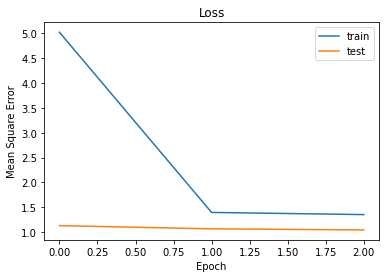

In [97]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.legend()
plt.savefig("loss.png", dpi = 800)

In [15]:
output = pd.DataFrame()

In [16]:
for image, label in iterator_test:
    pred = model.predict(image)
    add = pd.DataFrame({'True':[float(label)] , 'Prediction': [float(pred)], 'Difference':[float(label-pred)]})
    output = pd.concat([output,add], ignore_index=True)

difs = output.Difference.abs()
difs.describe()

count    4746.000000
mean        0.791877
std         0.631467
min         0.000031
25%         0.264003
50%         0.663935
75%         1.168201
max         4.083178
Name: Difference, dtype: float64

In [1]:
difs.hist(bins = 50)
plt.title("Distribution of difference between predicted and true temperatures")
plt.xlabel('Difference')
plt.ylabel('Count')
plt.savefig("Diff_Dist.png", dpi = 800)


NameError: name 'difs' is not defined